In [1]:
include("../../src/pottsmc.jl")
using CairoMakie
cd("d:\\Projects\\Potts-QCD\\potts-model-monte-carlo")

# Increase with order

In [2]:
pwd()

"d:\\Projects\\Potts-QCD\\potts-model-monte-carlo"

In [3]:
suzz_kth(m_arr, T, nsites, k) = (1/T) * (nsites) * cumulant(m_arr, k)

suzz_kth (generic function with 1 method)

In [4]:
lattice_sizes1, temps1, suzzs1, errors1 = let
    lattice_sizes=[16, 24, 32, 40]
    temps = [0.7, 0.9, 0.94, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0, 1.004, 1.008, 1.012, 1.016, 1.02, 1.06,  1.1, 1.3]
    max_order = 5
    errors = zeros(Float64, (length(lattice_sizes), max_order, length(temps)))
    suzzs = zeros(Float64, (length(lattice_sizes), max_order, length(temps)))
    for stepL in eachindex(lattice_sizes)
        L = lattice_sizes[stepL]
        for idx in eachindex(temps)
            T = temps[idx]
            mags = readdlm(joinpath("data", "2DModel", "Size$(L)", "mags", "potts_mags_temp$(T)_L$(L).txt"), ',', Float64)
            mags ./= L^2
            mags_def = 1
            suzzs[stepL, 1, idx] = mean(mags[mags_def, :])
            errors[stepL, 1, idx] = bootstrap_err(mags[mags_def, :], mean)
            for order_k in 2:max_order
                suzzs[stepL, order_k, idx] = suzz_kth(mags[mags_def, :], T, L*L, order_k)
                errors[stepL, order_k, idx] = bootstrap_err(mags[mags_def, :], suzz_kth, T, L*L, order_k; r=200)
            end
        end
    end
    lattice_sizes, temps, suzzs, errors
end;

In [25]:
for order in 1:5
    let T_c = 1/log1p(sqrt(3))
        f1 = Figure(resolution=(1200, 800))
        ax1 = Axis(f1[1, 1], xlabel="T", ylabel="⟨m⟩⁽ᵏ⁾ₕ", title="Order $(order-1) derivative of ⟨m⟩ with respect to h as h → 0")
        for stepL in eachindex(lattice_sizes1)
            L = lattice_sizes1[stepL]
            errorbars!(ax1, temps1, suzzs1[stepL, order, :], errors1[stepL, order, :], whiskerwidth = 5)
            scatterlines!(ax1, temps1, suzzs1[stepL, order, :], markersize = 5, label="size=$(L)×$(L)", linestyle = :dot)
        end
        vlines!(ax1, [T_c], linestyle = :dash, color = :black)
        axislegend(ax1, position=:lt)
        save("plots/2DModel/cumulants/order_$(order).svg", f1)
    end
end

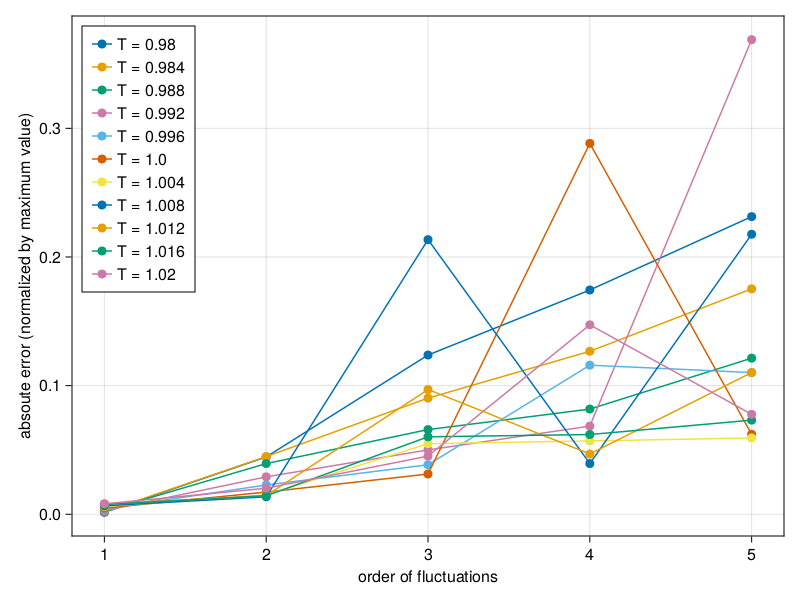

In [74]:
max_order = 5
# normalized_absolute_errors1 = similar(errors1)
# for r in 1:size(errors1, 1)
#     @views normalized_absolute_errors1[r, :] .= 2 .* errors1[r, :] ./ maximum(suzzs1[r, :])
# end

normalized_absolute_errors1 = errors1 ./ abs.(suzzs1)

length(temps)
f2 = Figure()
ax2 = Axis(f2[1, 1], xlabel="order of fluctuations", ylabel="absoute error (normalized by maximum value)")

for (idx, err_tmp) in enumerate(eachcol(normalized_absolute_errors1))
    scatterlines!(ax2, 1:max_order, err_tmp, label="T = $(temps1[idx])")
end

axislegend(ax2, position=:lt)
display(f2)

# Increase with system size

In [97]:
temps2, sizes, suzzs2, errors2 = let order_k=5
    sizes = [16, 24, 32, 40]
    temps = [0.992, 0.996, 1.0, 1.004, 1.008]
    errors = zeros(Float64, (length(sizes), length(temps)))
    suzzs = zeros(Float64, (length(sizes), length(temps)))
    suzz_kth(m_arr, T, nsites, k) = (1/T) * (nsites) * cumulant(m_arr, k)
    for idxL in eachindex(sizes)
        L = sizes[idxL]
        for idx in eachindex(temps)
            T = temps[idx]
            mags = readdlm(joinpath("data", "2DModel", "Size$(L)", "mags", "potts_mags_temp$(T)_L$(L).txt"), ',', Float64)
            mags ./= L^2
            mags_def = 2
            suzzs[1, idx] = mean(mags[mags_def, :])
            errors[1, idx] = bootstrap_err(mags[mags_def, :], mean)
            suzzs[idxL, idx] = suzz_kth(mags[mags_def, :], T, L*L, order_k)
            errors[idxL, idx] = bootstrap_err(mags[mags_def, :], suzz_kth, T, L*L, order_k; r=200)
        end
    end
    temps, sizes, suzzs, errors
end;

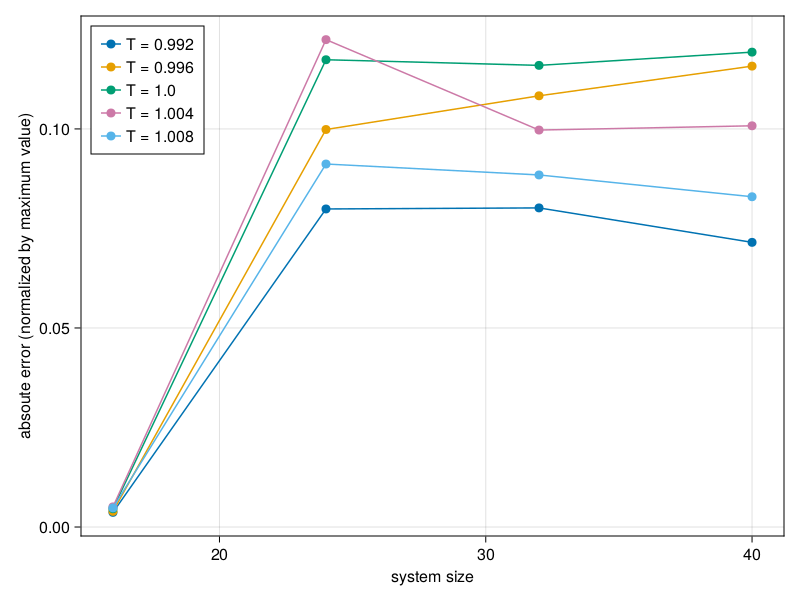

In [98]:
normalized_absolute_errors2 = similar(errors2)
for r in 1:size(errors2, 1)
    @views normalized_absolute_errors2[r, :] .= 2 .* errors2[r, :] ./ maximum(suzzs2[r, :])
end

f3 = Figure()
ax3 = Axis(f3[1, 1], xlabel="system size", ylabel="absoute error (normalized by maximum value)")

for (idx, err_tmp) in enumerate(eachcol(normalized_absolute_errors2))
    scatterlines!(ax3, sizes, err_tmp, label="T = $(temps2[idx])")
end

axislegend(ax3, position=:lt)
display(f3)

# Metropolis

In [11]:
temps3, suzzs3, errors3 = let L = 40
    temps = [0.7, 0.9, 0.94, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0, 1.004, 1.008, 1.012, 1.016, 1.02, 1.06,  1.1, 1.3]
    max_order = 5
    errors = zeros(Float64, (max_order, length(temps)))
    suzzs = zeros(Float64, (max_order, length(temps)))
    for idx in eachindex(temps)
        T = temps[idx]
        mags = readdlm(joinpath("data", "metro", "2DModel", "Size$(L)", "mags", "potts_mags_temp$(T)_L$(L).txt"), ',', Float64)
        mags ./= L^2
        mags_def = 1
        suzzs[1, idx] = mean(mags[mags_def, :])
        errors[1, idx] = bootstrap_err(mags[mags_def, :], mean)
        for order_k in 2:max_order
            suzzs[order_k, idx] = suzz_kth(mags[mags_def, :], T, L*L, order_k)
            errors[order_k, idx] = bootstrap_err(mags[mags_def, :], suzz_kth, T, L*L, order_k; r=200)
        end
    end
    temps, suzzs, errors
end;

In [24]:
let L = 40, T_c = 1/log1p(sqrt(3))
    for order in 1:5
        f3 = Figure(resolution=(1200, 800))
        ax3 = Axis(f3[1, 1], xlabel="T", ylabel="Order k fluctuations", title="Order $(order-1) fluctuations")
        errorbars!(ax3, temps3, suzzs3[order, :], errors3[order, :], whiskerwidth = 5)
        scatterlines!(ax3, temps3, suzzs3[order, :], markersize = 5, linestyle = :dot)
        vlines!(ax3, [T_c], linestyle=:dash, color=:black)
        save("plots/2DModel/cumulants/metro/order_$(order).svg", f3)
    end
end

# Miscellaneous

In [ ]:
# Test cumulants
let L=40, T=0.5
    order = 3
    function cumul_order(x, order)
        if order==1
            return mean(x)
        elseif order==2
            return moment(x, 2)
        elseif order==3
            return moment(x, 3)
        elseif order==4
            return moment(x, 4) - 3*moment(x, 2)^2
        elseif order==5
            return moment(x, 5) - 10*moment(x,3)*moment(x,2)
        elseif order==6
            return moment(x, 6) - 15*moment(x,4)*moment(x,2) - 10*moment(x,3)^2 + 30*moment(x,2)^3
        end
    end

    mags = readdlm(joinpath("data", "2DModel", "Size$(L)", "mags", "potts_mags_temp$(T)_L$(L).txt"), ',', Float64)
    mags ./= L^2
    suzz_kth(m_arr, T, nsites, k) = (1/T) * (nsites) * cumulant(m_arr, k)
    mags_def = 1
    m_arr = mags[1, :]
    suzz_a = (1/T) * (L*L) * cumulant(m_arr, order)
    suzz_b = (1/T) * (L*L) * cumul_order(m_arr, order)
    println("suzz_a = ", suzz_a)
    println("suzz_b = ", suzz_b)
end